In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers.schedules import CosineDecay
import joblib
import warnings
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Bidirectional
# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')


In [2]:
# Load dataset
df = pd.read_csv("data/food_demand_final.csv")

# Separate features and target variable
X = df.drop(columns=['Food Demand'])  # Features
y = df['Food Demand'].values.reshape(-1, 1)  # Target variable reshaped for scaling

In [3]:
df.head()

,City,Latitude,Longitude,Temperature,Rainfall,Population Growth Factor,Holiday,Day of Week,Unemployment Rate (%),Median Income ($),...,Day,Lag_7,Lag_14,Lag_30,Rolling_Mean_7,Rolling_Mean_14,EMA_7,EMA_14,Fourier_7,Fourier_14
0,4,40.7128,-74.006,29.7,10.8,1.034,0,1,6.579397,55075.814734,...,31,3317.1,3519.7,5658.7,3512.157143,3696.557143,3512.417509,3656.321674,3453.965182,3466.549210
1,4,40.7128,-74.006,30.9,14.0,1.034,0,2,7.047961,31797.113690,...,1,3354.9,3190.8,3848.8,3557.500000,3730.950000,3552.388132,3658.452117,3453.961815,3466.520106
2,4,40.7128,-74.006,19.0,4.2,1.034,1,3,8.758204,48009.532071,...,2,3436.7,3542.0,3557.2,3589.985714,3739.671429,3580.316099,3659.205168,3453.958433,3466.490871
3,4,40.7128,-74.006,28.4,7.0,1.034,0,4,6.784446,61871.495075,...,3,3692.3,3286.5,3000.0,3533.500000,3740.414286,3509.462074,3610.897813,3453.955037,3466.461511
4,4,40.7128,-74.006,18.7,9.4,1.034,0,5,6.072800,33922.819067,...,4,3977.3,3786.8,3565.1,3479.085714,3726.814286,3531.196556,3608.964771,3453.951626,3466.432029


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7290 entries, 0 to 7289
Data columns (total 37 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   City                           7290 non-null   int64  
 1   Latitude                       7290 non-null   float64
 2   Longitude                      7290 non-null   float64
 3   Temperature                    7290 non-null   float64
 4   Rainfall                       7290 non-null   float64
 5   Population Growth Factor       7290 non-null   float64
 6   Holiday                        7290 non-null   int64  
 7   Day of Week                    7290 non-null   int64  
 8   Unemployment Rate (%)          7290 non-null   float64
 9   Median Income ($)              7290 non-null   float64
 10  Food Price Index               7290 non-null   float64
 11  Inflation Rate (%)             7290 non-null   float64
 12  Stock Availability (%)         7290 non-null   f

In [5]:
df.describe()

,City,Latitude,Longitude,Temperature,Rainfall,Population Growth Factor,Holiday,Day of Week,Unemployment Rate (%),Median Income ($),...,Day,Lag_7,Lag_14,Lag_30,Rolling_Mean_7,Rolling_Mean_14,EMA_7,EMA_14,Fourier_7,Fourier_14
count,7290.000000,7290.000000,7290.000000,7290.000000,7290.000000,7290.000000,7290.000000,7290.000000,7290.000000,7290.000000,...,7290.000000,7290.000000,7290.000000,7290.000000,7290.000000,7290.000000,7290.000000,7290.000000,7290.000000,7290.000000
mean,4.502058,35.183258,-99.788315,18.788752,5.606818,1.025063,0.054870,2.995885,6.471361,54888.157217,...,15.719479,3451.968957,3452.534993,3453.028957,3451.949302,3452.190011,3451.963344,3452.183048,3452.790476,3452.737155
std,2.878203,4.254943,16.477048,7.445551,5.611074,0.012539,0.227741,2.002190,2.013053,14523.299707,...,8.815975,519.958488,521.037774,522.348982,207.310895,151.121062,211.433726,151.211080,13.059142,21.049570
min,0.000000,29.424100,-121.886300,-4.400000,-17.000000,1.010000,0.000000,0.000000,3.000772,30000.421611,...,1.000000,3000.000000,3000.000000,3000.000000,3143.228571,3204.221429,3133.938752,3216.072423,3423.100639,3418.543649
25%,2.000000,32.715700,-117.161100,13.400000,1.900000,1.016000,0.000000,1.000000,4.741148,42242.763722,...,8.000000,3114.925000,3115.250000,3115.025000,3343.992857,3364.703571,3332.351840,3365.871654,3443.499109,3438.404086
50%,5.000000,33.448400,-98.493600,18.400000,5.600000,1.018000,0.000000,3.000000,6.444155,54681.379443,...,16.000000,3372.800000,3373.000000,3372.800000,3401.271429,3411.771429,3407.318539,3419.682844,3453.684018,3449.976365
75%,7.000000,39.952600,-87.629800,24.200000,9.400000,1.034000,0.000000,5.000000,8.212362,67658.208946,...,23.000000,3635.000000,3635.225000,3635.400000,3478.421429,3522.617857,3504.757457,3495.449466,3462.432305,3462.121131
max,9.000000,41.878100,-74.006000,41.300000,25.000000,1.046000,1.000000,6.000000,9.999578,79985.883664,...,31.000000,10949.100000,10949.100000,10949.100000,7200.528571,5613.871429,6495.812179,5643.663910,3480.118876,3528.644404


In [4]:
df.isnull().sum()

City                             0
Latitude                         0
Longitude                        0
Temperature                      0
Rainfall                         0
Population Growth Factor         0
Holiday                          0
Day of Week                      0
Unemployment Rate (%)            0
Median Income ($)                0
Food Price Index                 0
Inflation Rate (%)               0
Stock Availability (%)           0
Transportation Efficiency (%)    0
Delivery Delays (%)              0
Storage Capacity (%)             0
Humidity (%)                     0
Air Quality Index                0
Heatwave                         0
Cold Wave                        0
Major Event                      0
Tourist Influx (%)               0
Food Demand                      0
Fuel Prices                      0
Holiday Indicator                0
Year                             0
Month                            0
Day                              0
Lag_7               

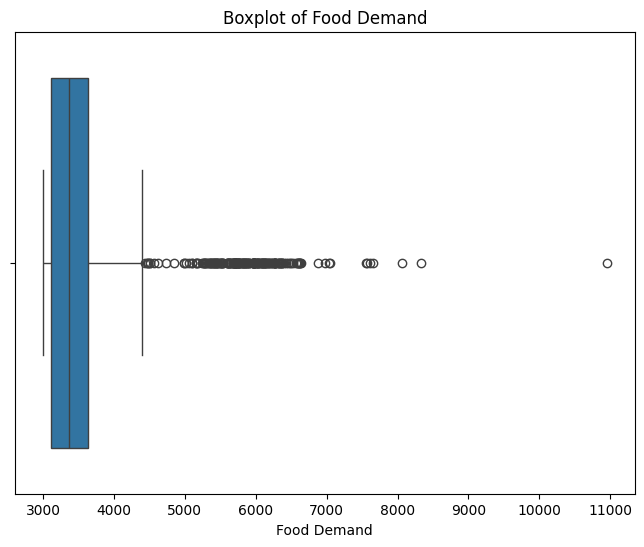

In [8]:
# box plot
plt.figure(figsize=(8,6))
sns.boxplot(data=df, x="Food Demand")
plt.title("Boxplot of Food Demand")
plt.show()

In [9]:
# REMOVING OUTLIERS
q1=df["Food Demand"].quantile(0.25)
q3=df["Food Demand"].quantile(0.75)
iqr=abs(q3-q1)
df=df[(df["Food Demand"]>=(q1-1.5*iqr)) & (df["Food Demand"]<=(q3+1.5*iqr))]

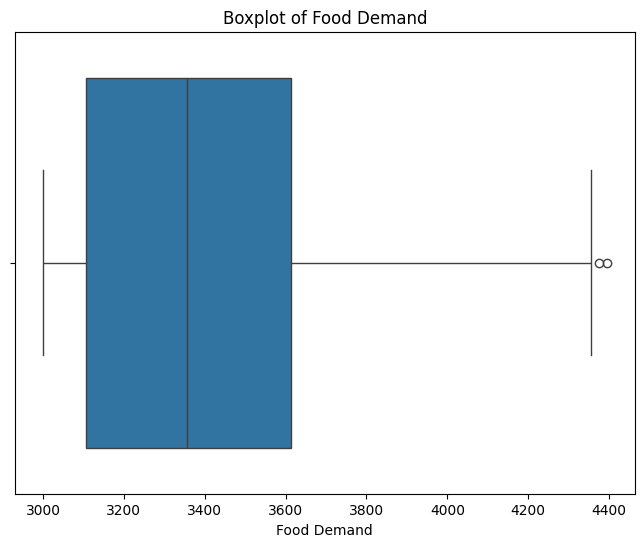

In [10]:
# box plot
plt.figure(figsize=(8,6))
sns.boxplot(data=df, x="Food Demand")
plt.title("Boxplot of Food Demand")
plt.show()

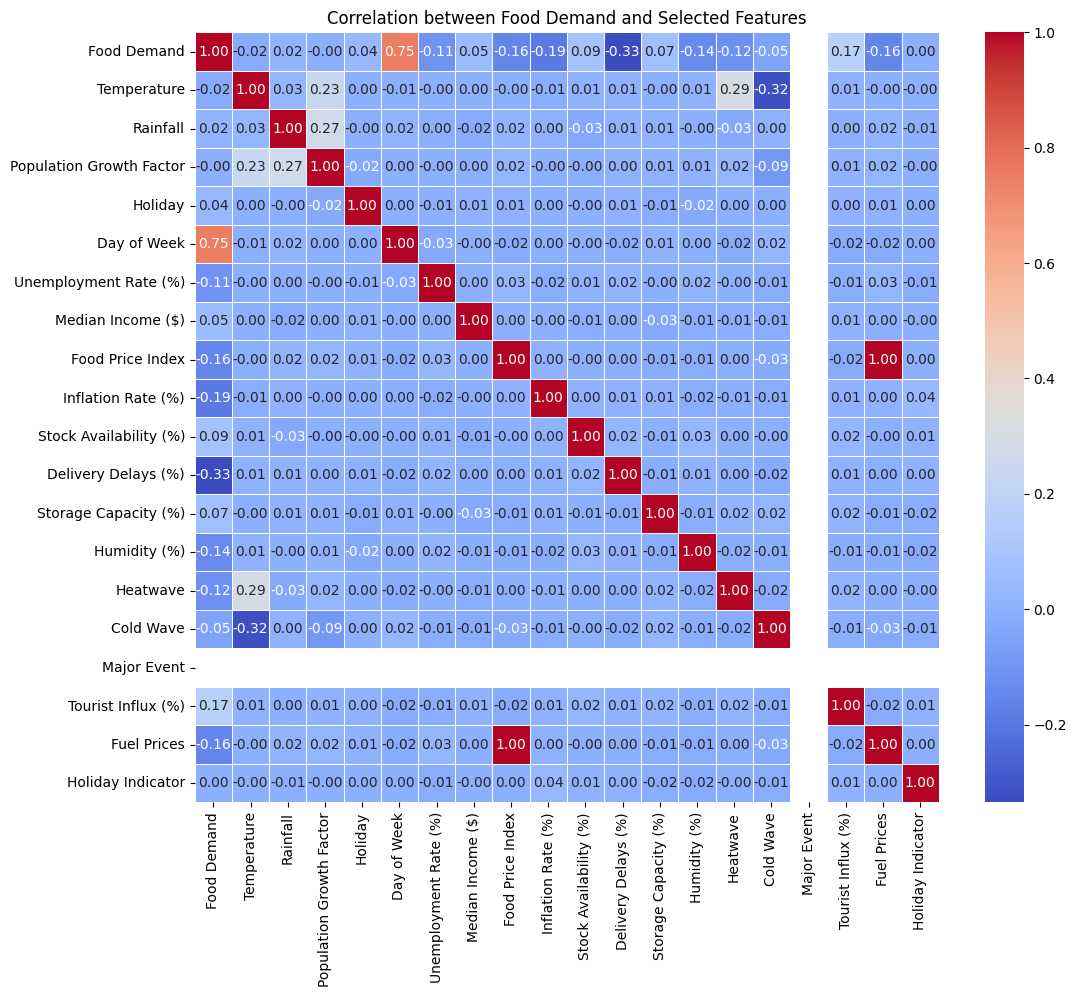

In [11]:
# Select columns related to food demand and multiple other features
columns_of_interest = ['Food Demand','Temperature', 'Rainfall', 'Population Growth Factor', 'Holiday', 'Day of Week', 'Unemployment Rate (%)', 'Median Income ($)', 'Food Price Index', 'Inflation Rate (%)', 'Stock Availability (%)', 'Delivery Delays (%)', 'Storage Capacity (%)', 'Humidity (%)', 'Heatwave', 'Cold Wave', 'Major Event', 'Tourist Influx (%)', 'Fuel Prices', 'Holiday Indicator']  # Replace with your actual feature names
correlation_matrix = df[columns_of_interest].corr()

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title(f"Correlation between Food Demand and Selected Features")
plt.show()

In [12]:
# Split dataset into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

In [13]:
# Normalize features using MinMaxScaler
scaler_X = MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# Normalize target variable (y) for LSTM
scaler_y = MinMaxScaler()
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1))


In [18]:
# Save scalers
joblib.dump(scaler_X, "models/scaler_X.pkl")
joblib.dump(scaler_y, "models/modelsscaler_y.pkl")

['models/modelsscaler_y.pkl']

In [19]:
# Define and train XGBoost model
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
xgb_model.fit(X_train_scaled, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [20]:
# Predict using XGBoost model
xgb_predictions = xgb_model.predict(X_test_scaled)

In [21]:
# Evaluate XGBoost performance
xgb_mae = mean_absolute_error(y_test, xgb_predictions)
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_predictions))
xgb_r2 = r2_score(y_test, xgb_predictions)

print(f"XGBoost Performance:\nMAE: {xgb_mae:.4f}, RMSE: {xgb_rmse:.4f}, R² Score: {xgb_r2:.4f}")
accuracy = (1 - (xgb_mae / np.mean(y_test))) * 100 
print(accuracy)

XGBoost Performance:
MAE: 78.7888, RMSE: 104.3845, R² Score: 0.9540
97.7070279659527


In [22]:
# Save the trained XGBoost model
joblib.dump(xgb_model, "models/xgb_model.pkl")

['models/xgb_model.pkl']

In [23]:

# Prepare data for LSTM
time_steps = 10  # Number of past days used for prediction
print(f"X_train_scaled shape: {X_train_scaled.shape}")
print(f"y_train_scaled shape: {y_train_scaled.shape}")

def create_sequences(X, y, time_steps):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):  # Prevent IndexError
        Xs.append(X[i : i + time_steps])
        ys.append(y[i + time_steps - 1])  # Adjust index to stay within bounds
    return np.array(Xs), np.array(ys).reshape(-1, 1)




X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, time_steps)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, time_steps)

# Define LSTM model
lstm_model = Sequential([
    Bidirectional(LSTM(64, return_sequences=True, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]))),
    Dropout(0.2),
    LSTM(32, return_sequences=False),
    Dropout(0.2),
    Dense(1)
])

# Compile LSTM model
lstm_model.compile(optimizer='adam', loss='mse')

# Train LSTM model
lstm_model.fit(X_train_seq, y_train_seq, epochs=50, batch_size=32, validation_data=(X_test_seq, y_test_seq), verbose=1)

# Save trained LSTM model
# lstm_model.save("lstm_model.h5")

# Predict using LSTM model
lstm_predictions = lstm_model.predict(X_test_seq)

# Inverse transform LSTM predictions to original scale
lstm_predictions = scaler_y.inverse_transform(lstm_predictions)
y_test_seq = scaler_y.inverse_transform(y_test_seq)  # Ensure correct shape

X_train_scaled shape: (5832, 36)
y_train_scaled shape: (5832, 1)
Epoch 1/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0077 - val_loss: 0.0019
Epoch 2/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0024 - val_loss: 7.5833e-04
Epoch 3/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0018 - val_loss: 5.8106e-04
Epoch 4/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0012 - val_loss: 4.3885e-04
Epoch 5/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0010 - val_loss: 3.0492e-04
Epoch 6/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 8.9176e-04 - val_loss: 3.0150e-04
Epoch 7/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 8.1239e-04 - val_loss: 4.3788e-04
Epoch 8/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 7.9364e-04 - val_loss: 2.8980e-04
Epoch 9/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 6.5248e-04 - val_loss: 2.5680e-04
Epoch 10/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 6.6570e-04 - val_loss: 2.3670e-04
Epoch 11/50
182/18

In [24]:
# Evaluate LSTM model performance
lstm_mae = mean_absolute_error(y_test_seq, lstm_predictions)
lstm_rmse = np.sqrt(mean_squared_error(y_test_seq, lstm_predictions))
lstm_r2 = r2_score(y_test_seq, lstm_predictions)

print(f"LSTM Performance:\nMAE: {lstm_mae:.4f}, RMSE: {lstm_rmse:.4f}, R² Score: {lstm_r2:.4f}")
accuracy = (1 - (lstm_mae/ np.mean(y_test_seq))) * 100 
print(accuracy)

LSTM Performance:
MAE: 75.2718, RMSE: 96.7040, R² Score: 0.9607
97.80927814155318


In [25]:
# Save trained LSTM model
lstm_model.save("models/lstm_model.h5")

In [26]:
# Combine XGBoost and LSTM predictions for Hybrid Model
xgb_predictions_trimmed = xgb_predictions[time_steps:]  # Align XGBoost predictions with LSTM output
hybrid_predictions = 0.1 * xgb_predictions_trimmed + 0.9 * lstm_predictions.flatten()


In [27]:

# Evaluate Hybrid Model
hybrid_mae = mean_absolute_error(y_test_seq, hybrid_predictions)
hybrid_rmse = np.sqrt(mean_squared_error(y_test_seq, hybrid_predictions))
hybrid_r2 = r2_score(y_test_seq, hybrid_predictions)

print(f"Optimized Hybrid Model Performance:\nMAE: {hybrid_mae:.4f}, RMSE: {hybrid_rmse:.4f}, R² Score: {hybrid_r2:.4f}")
accuracy = (1 - (hybrid_mae/ np.mean(y_test_seq))) * 100 
print(accuracy)

Optimized Hybrid Model Performance:
MAE: 86.1679, RMSE: 116.4774, R² Score: 0.9430
97.49215680778245
